In [1]:
import numpy as np
import os
from torch.utils.data import Dataset
import librosa
import torch
import matplotlib.pyplot as plt
from torch import nn
import tqdm
import torchvision
from sklearn.metrics import roc_curve


from torchvision.models import resnet18

device =  'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using {device}")

Using cuda


In [32]:
def pad_random(x: np.ndarray, max_len: int = 64000):
    x_len = x.shape[0]
    if x_len > max_len:
        stt = np.random.randint(x_len - max_len)
        return x[stt:stt + max_len]

    num_repeats = int(max_len / x_len) + 1
    padded_x = np.tile(x, (num_repeats))
    return pad_random(padded_x, max_len)

class SVDD2024(Dataset):
    """
    Dataset class for the SVDD 2024 dataset.
    """
    def __init__(self, base_dir, partition="train", max_len=64000):
        assert partition in ["train", "dev", "test"], "Invalid partition. Must be one of ['train', 'dev', 'test']"
        self.base_dir = base_dir
        self.partition = partition
        self.base_dir = os.path.join(base_dir, partition + "_set")
        self.max_len = max_len

        self.transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224))])
        
        try:
            with open(os.path.join(base_dir, f"{partition}.txt"), "r") as f:
                self.file_list = f.readlines()
        except FileNotFoundError:
            if partition == "test":
                self.file_list = []
                # get all *.flac files in the test_set directory
                for root, _, files in os.walk(self.base_dir):
                    for file in files:
                        if file.endswith(".flac"):
                            self.file_list.append(file)
            else:
                raise FileNotFoundError(f"File {partition}.txt not found in {base_dir}")


            
    
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):            
        if self.partition == "test":
            file_name = self.file_list[index].strip()
            label = 0 # dummy label. Not used for test set.
        else:
            file = self.file_list[index]
            file_name = file.split(" ")[2].strip()
            bonafide_or_spoof = file.split(" ")[-1].strip()
            label = 1 if bonafide_or_spoof == "bonafide" else 0
        try:
            x, _ = librosa.load(os.path.join(self.base_dir, file_name + ".flac"), sr=16000, mono=True)
            x = pad_random(x, self.max_len) # x = pad_random (audio,64000)
            #x = librosa.util.normalize(x)
            #x = librosa.feature.melspectrogram(y=x, sr=16000)
            #x = librosa.feature.chroma_cqt(y=x,sr=16000)
            #x = np.abs(librosa.stft(x))
            x = librosa.feature.melspectrogram(y=x, sr=16000, n_mels=128,
                                    fmax=8000)
            x= librosa.amplitude_to_db(x,ref=np.max)
            #x = librosa.display.specshow(x, x_axis='time',
            #             y_axis='mel', sr=16000,
            #             fmax=8000)
            # file_name is used for generating the score file for submission
            return self.transforms(torch.unsqueeze(torch.from_numpy(x),dim=0)), label, file_name

        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            return None

In [33]:
train_ds=SVDD2024('./temp/ds/',partition='train')
test_ds=SVDD2024('./temp/ds/',partition='dev')

In [34]:
print(len(train_ds))
print(len(test_ds))

84404
43625


In [35]:
train_loader=torch.utils.data.DataLoader(train_ds,batch_size=16)
test_loader=torch.utils.data.DataLoader(test_ds,batch_size=16)

torch.Size([1, 224, 224])


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

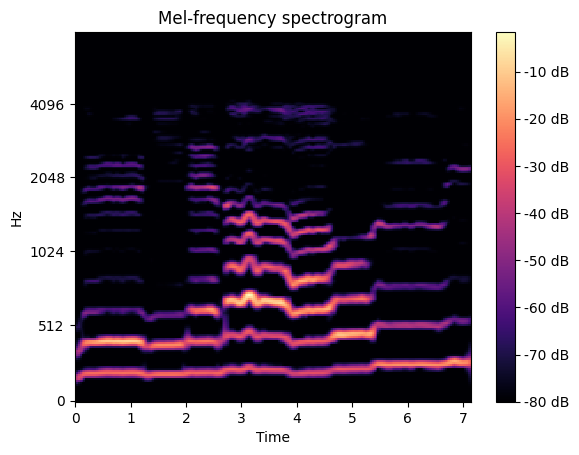

In [39]:
print(train_ds[0][0].shape)
fig, ax = plt.subplots()
img = librosa.display.specshow(np.asanyarray(train_ds[0][0][0]), x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [7]:
model=mobilenet_v3_small()

In [8]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [9]:
model.features[0][0]=nn.Conv2d(1,16,kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.classifier[3]=nn.Linear(in_features=1024, out_features=1, bias=True)

In [10]:
with torch.inference_mode():
    print(model(torch.rand((1,1,224,224))))

tensor([[-0.0244]])


In [11]:
def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)

In [12]:
dt=next(iter(train_loader))
loss_fn=nn.BCEWithLogitsLoss()

with torch.inference_mode():
    x=dt[0]
    y=dt[1]
    logits=model(x)
    print(torch.sigmoid(logits).squeeze())
    print(y.type(torch.float32))
    print(loss_fn(logits.squeeze(),y.type(torch.float32)))

tensor([0.4920, 0.4970, 0.4932, 0.4917, 0.4959, 0.4958, 0.4973, 0.4930, 0.4884,
        0.4919, 0.4964, 0.4881, 0.4930, 0.4978, 0.4991, 0.4879])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(0.7059)


In [13]:
def train_model(model, epochs):
    model = model.to(device)
    optimizer = torch.optim.Adam(params=model.parameters())
    loss_fn = nn.BCEWithLogitsLoss()

    for i in tqdm.notebook.tqdm(range(epochs)):
        train_preds = torch.tensor([], device=device)
        val_preds = torch.tensor([], device=device)
        train_actual = torch.tensor([], device=device)
        val_actual = torch.tensor([], device=device)
        
        print("\nTraining:")
        model.train()
        
        temp_train_loss = []
        temp_val_loss = []
    
        net_train_loss = 0
        net_val_loss = 0
        
        with tqdm.notebook.tqdm(total=len(train_loader)) as pbar:
            for x, y, _ in train_loader:
                x = x.to(device)
                y = y.to(device).type(torch.float32)

                logits = model(x)
        
                optimizer.zero_grad()
                loss = loss_fn(logits.squeeze(), y)
                
                preds = torch.sigmoid(logits).detach().squeeze()
                train_preds = torch.cat((train_preds, preds))
                train_actual = torch.cat((train_actual, y))
                
                temp_train_loss.append(loss.item())
                
                loss.backward()
                optimizer.step()
                
                pbar.update(1)
            pbar.close()
        
        net_train_loss = sum(temp_train_loss) / len(temp_train_loss)
    
        print("Testing:")
        model.eval()
    
        with tqdm.notebook.tqdm(total=len(test_loader)) as pbar2:
            for x, y, _ in test_loader:
                x = x.to(device)
                y = y.to(device).type(torch.float32)
                
                with torch.inference_mode():
                    logits = model(x)
                    loss = loss_fn(logits.squeeze(), y.type(torch.float32))
                    
                    preds = torch.sigmoid(logits).detach().squeeze()
                    val_preds = torch.cat((val_preds, preds))
                    val_actual = torch.cat((val_actual, y))
                    
                    temp_val_loss.append(loss.item())
    
                    pbar2.update(1)
            pbar2.close()
    
        net_val_loss = sum(temp_val_loss) / len(temp_val_loss)
        
        fpr, tpr, thresholds = roc_curve(val_actual.cpu().numpy(), val_preds.cpu().numpy())
        fnr = 1 - tpr
        eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
        eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        
        print(f"\nEpoch {i+1}:\nTrain Loss: {net_train_loss}\nVal Loss: {net_val_loss}\nEER: {eer}\nEER Threshold: {eer_threshold}\n")


In [ ]:
train_model(model,100)

  0%|          | 0/100 [00:00<?, ?it/s]


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 1:
Train Loss: 0.0769293124449216
Val Loss: 5.660528757462733
EER: 0.5062570796698851
EER Threshold: 2.672253807123326e-10


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 2:
Train Loss: 0.0740489491338822
Val Loss: 2.09499105791667
EER: 0.5084686336911376
EER Threshold: 9.164087373392249e-07


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 3:
Train Loss: 0.08644562237377326
Val Loss: 2.4504751822445585
EER: 0.510248664976536
EER Threshold: 4.1718253669387195e-06


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 4:
Train Loss: 0.09596366911275547
Val Loss: 2.6653949025023134
EER: 0.4898592157074276
EER Threshold: 6.86208778688524e-08


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 5:
Train Loss: 0.08923281270672191
Val Loss: 1.6510364283615309
EER: 0.5096553212147366
EER Threshold: 1.893594344437588e-05


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 6:
Train Loss: 0.11392243136309892
Val Loss: 1.933896936578783
EER: 0.5240304223528777
EER Threshold: 2.38813845498953e-06


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 7:
Train Loss: 0.07950246644453057
Val Loss: 1.7115569938533752
EER: 0.5287771724472733
EER Threshold: 9.928804502123967e-06


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 8:
Train Loss: 0.1397675852744844
Val Loss: 3.332640524748423
EER: 0.5257025729543126
EER Threshold: 2.8349958491880045e-10


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 9:
Train Loss: 0.10893199753407841
Val Loss: 1.6266538598980458
EER: 0.5099789632666271
EER Threshold: 2.030367249972187e-05


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 10:
Train Loss: 0.14139344087161584
Val Loss: 1.6727851899453288
EER: 0.509088947623928
EER Threshold: 1.3470225894707255e-05


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 11:
Train Loss: 0.10601508275595871
Val Loss: 2.2755377190616395
EER: 0.5701763849182804
EER Threshold: 2.3475421073726466e-07


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 12:
Train Loss: 0.17203479247628295
Val Loss: 2.746082020133148
EER: 0.48635309347861266
EER Threshold: 1.139520211523859e-08


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 13:
Train Loss: 0.1267365302629716
Val Loss: 1.8766078592874367
EER: 0.5101677544635633
EER Threshold: 2.6941304440697422e-06


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 14:
Train Loss: 0.20947588544312565
Val Loss: 2.0615821212794074
EER: 0.492097739899671
EER Threshold: 6.160493057905114e-07


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 15:
Train Loss: 0.11860479201364978
Val Loss: 2.327218203264798
EER: 0.48648794433356707
EER Threshold: 3.855035970445897e-07


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 16:
Train Loss: 0.1413222825779824
Val Loss: 17.490432901784228
EER: 0.3419008576514375
EER Threshold: 2.943739913871823e-39


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 17:
Train Loss: 0.22713029226029638
Val Loss: 2.691727181184992
EER: 0.5038297642807056
EER Threshold: 1.2461088161330736e-08


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 18:
Train Loss: 0.15613270876268065
Val Loss: 4.805769466021108
EER: 0.5256756027833216
EER Threshold: 2.2672274671689313e-15


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 19:
Train Loss: 0.1478610847512718
Val Loss: 1.8393722037271667
EER: 0.5080371109552835
EER Threshold: 4.1700832298374735e-06


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 20:
Train Loss: 0.34232472276686066
Val Loss: 1.992554825539776
EER: 0.5246777064566589
EER Threshold: 1.0343331950934953e-06


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 21:
Train Loss: 0.17422614507118508
Val Loss: 2.2049121585132943
EER: 0.47772263876152976
EER Threshold: 1.0370705894047205e-07


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 22:
Train Loss: 0.16983406083946487
Val Loss: 2.2202329135151855
EER: 0.48621824262365826
EER Threshold: 1.5059944757922494e-07


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 23:
Train Loss: 0.20643974165181475
Val Loss: 2.141574111353061
EER: 0.49816602837261986
EER Threshold: 8.545747505195322e-07


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 24:
Train Loss: 0.33087998151190773
Val Loss: 3.9733996666217313
EER: 0.5293705162090727
EER Threshold: 1.1313635439732725e-13


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 25:
Train Loss: 0.17434862545747903
Val Loss: 26.095987332263046
EER: 0.056745239764820106
EER Threshold: 3.100679736682345e-39


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 26:
Train Loss: 0.24877139878253263
Val Loss: 1.797464585016077
EER: 0.49247532229354335
EER Threshold: 5.473090368468547e-06


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 27:
Train Loss: 0.23201129972267762
Val Loss: 1.898970412818763
EER: 0.5228976751712606
EER Threshold: 3.079343287026859e-06


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 28:
Train Loss: 0.13140652351494952
Val Loss: 2.250675795434695
EER: 0.43276336371972596
EER Threshold: 1.4455230257226503e-07


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 29:
Train Loss: 0.13410176510111727
Val Loss: 1.8628294289922618
EER: 0.44943092939209234
EER Threshold: 2.958445520562236e-06


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 30:
Train Loss: 0.27266239580047624
Val Loss: 1.635031686955333
EER: 0.4884567668159016
EER Threshold: 2.588198913144879e-05


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 31:
Train Loss: 0.2645641111415165
Val Loss: 2.270829229408282
EER: 0.48532822698095907
EER Threshold: 2.3459125486624544e-07


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 32:
Train Loss: 0.16865051343586573
Val Loss: 2.544850218638303
EER: 0.47685959328982147
EER Threshold: 2.8371144367156376e-07


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 33:
Train Loss: 0.12532852058222735
Val Loss: 2.029671152984954
EER: 0.524650736285668
EER Threshold: 2.763532847893657e-06


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 34:
Train Loss: 0.15338943178677028
Val Loss: 4.287741003142069
EER: 0.5244349749177409
EER Threshold: 3.989264701995815e-13


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 35:
Train Loss: 0.1976083872825931
Val Loss: 1.6489113302962013
EER: 0.5027239872700793
EER Threshold: 2.3257682187249884e-05


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 36:
Train Loss: 0.4245211353783609
Val Loss: 1.953569357080192
EER: 0.4972490425589298
EER Threshold: 1.2061411780450726e-06


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 37:
Train Loss: 0.2305083027457495
Val Loss: 14.617098071541246
EER: 0.24437671934840066
EER Threshold: 2.99253873159347e-39


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 38:
Train Loss: 0.1616778689226182
Val Loss: 2.1650365925289647
EER: 0.4929607853713793
EER Threshold: 4.860430067310517e-07


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 39:
Train Loss: 0.30652700765054086
Val Loss: 17.075049327799046
EER: 0.17579157451858246
EER Threshold: 3.111272151774176e-39


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 40:
Train Loss: 0.22824773962943942
Val Loss: 1.761545844516096
EER: 0.4606505205243001
EER Threshold: 6.859725090180291e-06


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 41:
Train Loss: 0.22524016765153465
Val Loss: 2.687910594455325
EER: 0.4659097038675225
EER Threshold: 1.1974160329941697e-08


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 42:
Train Loss: 0.21042334238175012
Val Loss: 2.4389529681359545
EER: 0.4941474728949782
EER Threshold: 4.268942532803521e-08


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 43:
Train Loss: 0.27028306928189244
Val Loss: 7.903380060485479
EER: 0.5344948486973408
EER Threshold: 5.790167544173041e-29


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 44:
Train Loss: 0.17129334321810138
Val Loss: 1.8553905738208067
EER: 0.5410486002481256
EER Threshold: 3.905770427081734e-06


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 45:
Train Loss: 0.24152266804660535
Val Loss: 2.9747943190683013
EER: 0.48632612330762176
EER Threshold: 8.507753529451989e-11


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 46:
Train Loss: 0.4248026406358423
Val Loss: 2.1724044142546686
EER: 0.5750579858676304
EER Threshold: 9.337144319943036e-07


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 47:
Train Loss: 0.28785736837816184
Val Loss: 2.8387872142222674
EER: 0.5651059927719941
EER Threshold: 2.4332043047081697e-09


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 48:
Train Loss: 0.1592956403685351
Val Loss: 2.104611017546147
EER: 0.5011057770106262
EER Threshold: 5.434983449958963e-07


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 49:
Train Loss: 0.2010475883399134
Val Loss: 2.204848476501484
EER: 0.45328766384378877
EER Threshold: 1.45385001815157e-07


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing:


  0%|          | 0/2727 [00:00<?, ?it/s]


Epoch 50:
Train Loss: 0.1680217491639644
Val Loss: 3.351486295293242
EER: 0.466260316090404
EER Threshold: 1.7115687122801204e-12


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
torch.save(model.state_dict(),'epoch-100.pt')